In [44]:
# Importing Required Libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn
import numpy as np

In [45]:
# Reading data
data = pd.read_csv('/Users/hoosiersaikap251/dataviz/docs/Data.csv')

Taking Features Related to ROI Metric

| Feature Name                    | Description                                                                                 |
|--------------------------------|---------------------------------------------------------------------------------------------|
| business_impact_score          | Estimated business value or impact score (1-10)                                             |
| user_demand_score              | User demand or interest score (1-10 or based on upvotes/surveys)                            |
| customer_satisfaction_impact   | Impact on customer satisfaction or NPS (e.g., score 1-5)                                    |
| time_saved_per_user_minutes    | Estimated time saved per user per week in minutes                                          |
| num_users_impacted             | Number of users expected to be impacted                                                    |
| market_differentiation_score   | Score indicating how much this sets product apart in market (1-5)                          |
| revenue_potential_usd          | Projected revenue increase in USD from this feature                                        |
| cost_savings_usd               | Projected cost savings in USD from this feature                                            |
| scalability_potential_score    | Score indicating how scalable or reusable the idea is (1-5)                                |
| feature_adoption_likelihood    | Likelihood of feature adoption (percentage or 1-5 scale)                                   |


In [46]:

df_ROI = data[['Title','Description','business_impact_score', 'user_demand_score', 'customer_satisfaction_impact', 
               'time_saved_per_user_minutes', 'num_users_impacted', 'market_differentiation_score', 
               'revenue_potential_usd', 'cost_savings_usd', 'scalability_potential_score', 
               'feature_adoption_likelihood']].copy()

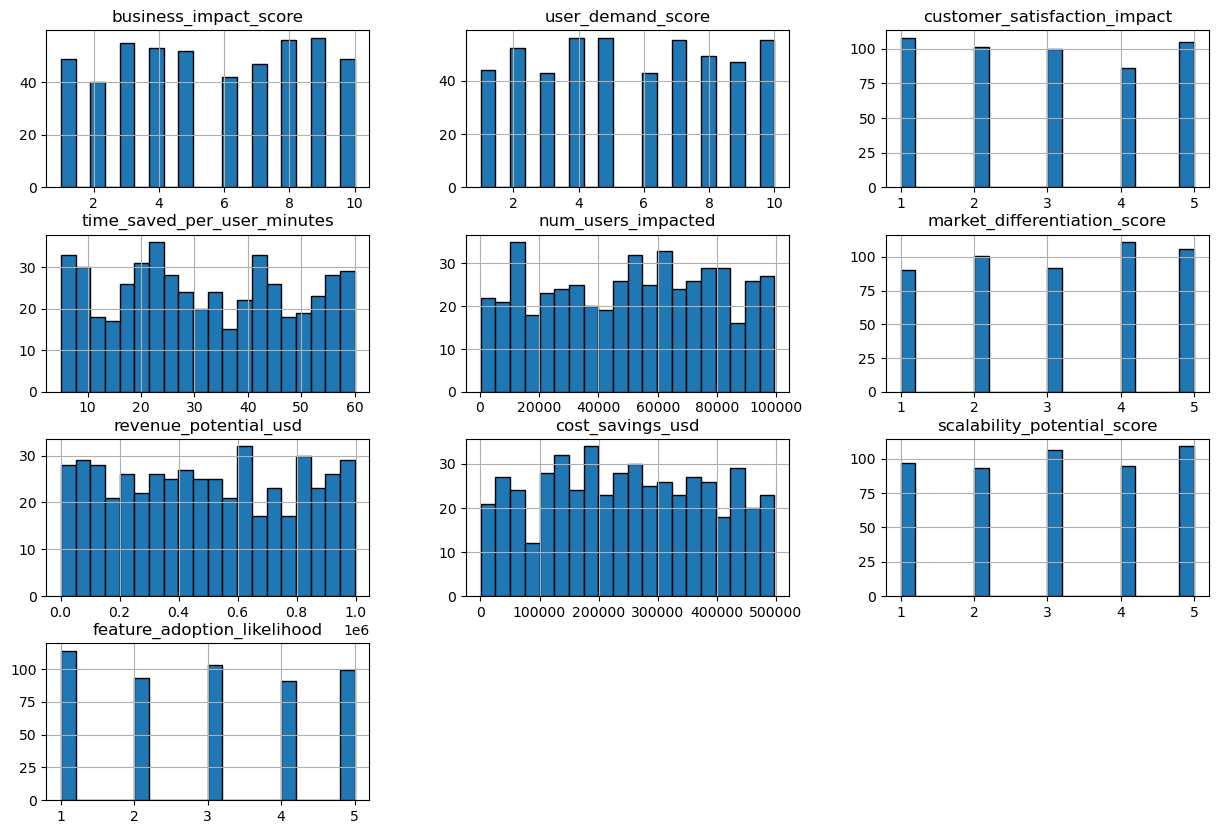

In [47]:
df_ROI.hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.show()

Normalizing the Data based on Min-Max Scaling 

In [ ]:
numerical_columns = df_ROI.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler(feature_range=(0, 1))
df_ROI_normalized = df_ROI.copy()
df_ROI_normalized[numerical_columns] = scaler.fit_transform(df_ROI[numerical_columns])
df_ROI_normalized.head(5)

,Title,Description,business_impact_score,user_demand_score,customer_satisfaction_impact,time_saved_per_user_minutes,num_users_impacted,market_differentiation_score,revenue_potential_usd,cost_savings_usd,scalability_potential_score,feature_adoption_likelihood
0,Intelligent Machine Service,Intelligent Machine Service aims at enhancing ...,0.555556,0.111111,0.75,0.763636,0.457039,0.75,0.751514,0.484002,0.50,0.75
1,Cloud-Based Local Optimizer,Cloud-Based Local Optimizer aims at optimizing...,0.666667,0.777778,0.50,0.254545,0.707034,0.50,0.945640,0.517658,0.25,1.00
2,Intelligent Establish Optimizer,Intelligent Establish Optimizer aims at enhanc...,0.666667,0.333333,0.00,0.690909,0.055478,0.00,0.092971,0.048161,0.50,0.75
3,Cloud-Based Ten System,Cloud-Based Ten System aims at enhancing autom...,0.777778,0.444444,1.00,0.000000,0.854390,0.50,0.920779,0.573102,1.00,0.50
4,Automated Six Manager,Automated Six Manager aims at improving compli...,0.444444,0.000000,0.75,0.581818,0.838421,1.00,0.892064,0.654300,0.50,0.50


In [51]:
# Keeping the Target Label Randomly 
df_ROI_normalized['target'] = np.random.rand(len(df_ROI_normalized))

In [52]:
# Train, Val and Test Split For Training Random Forest Model
from sklearn.model_selection import train_test_split

df_train,df_temp = train_test_split(df_ROI_normalized, train_size=300, random_state=42)
df_val, df_test = train_test_split(df_ROI_normalized, test_size=100, random_state=42)

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Training the Model
X = df_train[numerical_columns]
y = df_train['target']


rf_regressor = RandomForestRegressor(n_estimators=100,random_state=42)
rf_regressor.fit(X, y)

# Val Set
X_val = df_val[numerical_columns]
y_val = df_val['target']
y_pred = rf_regressor.predict(X_val)


mse = mean_squared_error(y_val, y_pred)
print(f"MSE: {mse}")

MSE: 0.030633387595094735


Feature importance indicates how much each feature contributes to the predictive power of the model.
Higher importance values mean the feature plays a bigger role in the model’s decisions.
This helps with model interpretability and can guide feature selection or engineering.

In [ ]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_
importances_df = pd.DataFrame({
    'Feature': numerical_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                        Feature  Importance
7              cost_savings_usd    0.181917
4            num_users_impacted    0.170888
6         revenue_potential_usd    0.159846
3   time_saved_per_user_minutes    0.123502
0         business_impact_score    0.084090
1             user_demand_score    0.068036
8   scalability_potential_score    0.059022
2  customer_satisfaction_impact    0.057495
9   feature_adoption_likelihood    0.051037
5  market_differentiation_score    0.044167


In [54]:
import altair as alt

# Create a histogram for feature importance
chart = alt.Chart(importances_df).mark_bar().encode(
    x=alt.X('Feature', sort='-y', title='Features'),
    y=alt.Y('Importance', scale=alt.Scale(domain=[0, 1]), title='Importance'),
    tooltip=['Feature', 'Importance']
).properties(
    title='Feature Importance Histogram',
    width=600,
    height=400
)

chart

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [55]:
feature_weights = pd.Series(feature_importances, index=X.columns)

In [56]:
df_train['roi_target'] = df_train[feature_weights.index].mul(feature_weights, axis=1).sum(axis=1)

In [57]:
df_train_sorted = df_train.sort_values(by='roi_target', ascending=False)
df_train_sorted.head(3)

,Title,Description,business_impact_score,user_demand_score,customer_satisfaction_impact,time_saved_per_user_minutes,num_users_impacted,market_differentiation_score,revenue_potential_usd,cost_savings_usd,scalability_potential_score,feature_adoption_likelihood,target,roi_target
309,Smart Among Service,Smart Among Service aims at improving complian...,0.888889,0.888889,1.00,1.000000,0.954263,0.00,0.934969,0.893503,0.00,0.25,0.968316,0.804046
27,Cloud-Based The Platform,Cloud-Based The Platform aims at improving com...,1.000000,0.111111,0.25,0.781818,0.853916,1.00,0.827504,0.959986,0.75,1.00,0.718652,0.794885
51,Zero-Touch Compare Agent,Zero-Touch Compare Agent aims at optimizing in...,0.666667,0.666667,0.25,0.600000,0.864303,0.25,0.985038,0.910764,0.75,1.00,0.146151,0.767074


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Test Set
X_val = df_test[numerical_columns]
y_test = df_test['target']
y_pred = rf_regressor.predict(X_val)


mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.10927649213434791


In [59]:
# Assigning Weights to the Features for whole Dataset
df_all_ROI=df_ROI_normalized.copy()
df_all_ROI['ROI_Score'] = df_all_ROI[feature_weights.index].mul(feature_weights, axis=1).sum(axis=1)

In [61]:
df_all_ROI.head(1)
df_all_ROI.to_csv('df_all_ROI.csv', index=False)